# Transformers for Peak Detection

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import math
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, f1_score
plt.style.use("seaborn-v0_8")
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing

In [5]:

csv_path = "/content/dataset_20.csv"
target = "CURRENT|6"
output_path = "/content/X_test_with_peaks.csv"

df = pd.read_csv(csv_path)
y = df[[target]].values
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)
df['y_scaled'] = y_scaled

#print(df.head())

print("\nDONE - Load and Normalize")

#print(df['y_scaled'].value_counts())


DONE - Load and Normalize


## Config

In [13]:
# 🧠 hyperparameters
FEATS = 1                  # Input feature dimension
WINDOW_SIZE = 10
D_MODEL = 8               # Model dimension (used for projecting input)
DIM_FEEDFORWARD = 64       # Hidden units in FFN
NUM_HEADS = 1              # Attention heads (must divide D_MODEL)
NUM_ENCODER_LAYERS = 1     # Transformer encoder layers
NUM_DECODER_LAYERS = 1     # Transformer decoder layers
DROPOUT = 0.1              # Dropout rate

# ----------- 1. Config ----------- #
window_size = 30
batch_size = 128
num_epochs = 60
lr = 0.001

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)  # create the folder if it doesn't exist


print("\nDONE - Config")



DONE - Config


### Sliding Windows

In [14]:
def create_windows(data, window_size):
    return np.array([data[i:i + window_size] for i in range(len(data) - window_size)])


X_all = create_windows(y_scaled, window_size)
y_all = X_all.copy()  # since it's reconstruction

print("\nDONE - Create Sliding Window")

# Flatten each window for saving and inspection
X_all_2d = X_all.reshape(X_all.shape[0], -1)
X_all_df = pd.DataFrame(X_all_2d)


DONE - Create Sliding Window


### Train Test Split

In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

X_train, X_test = train_test_split(X_all_df, test_size=0.2, random_state=42)
X_test.reset_index(drop=True, inplace=True)

# Convert to torch tensor for model
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(-1)  # [B, T, 1]
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(-1)

print("\nDONE - Train-Test Split")



DONE - Train-Test Split


## Model Building

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=DROPOUT, max_len=500):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create sinusoidal positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term[:(d_model // 2 + 1)])  # handles both even/odd d_model

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Add positional encoding to input tensor
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


class PeakAD_Transformer(nn.Module):
    def __init__(self):
        super().__init__()

        # Project input features into higher dimension
        self.input_proj = nn.Linear(FEATS, D_MODEL)

        # Add positional encoding for combined input + error sequence
        self.pos_encoder = PositionalEncoding(D_MODEL * 2, DROPOUT, window_size)

        # Define encoder block
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=NUM_ENCODER_LAYERS)

        # Define decoder block
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=D_MODEL * 2,
            nhead=NUM_HEADS,
            dim_feedforward=DIM_FEEDFORWARD,
            dropout=DROPOUT,
            batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=NUM_DECODER_LAYERS)

        # Output layer to project back to original feature dimension
        self.output_layer = nn.Sequential(
            nn.Linear(D_MODEL * 2, FEATS),
            nn.Sigmoid()
        )

    def encode(self, src, err, tgt):
        # Project source and error
        src_enc = self.input_proj(src)
        err_enc = self.input_proj(err)

        # Concatenate source and error for self-conditioning
        combined = torch.cat((src_enc, err_enc), dim=2)
        combined = combined * math.sqrt(D_MODEL)

        # Add positional encoding
        encoded = self.pos_encoder(combined)

        # Pass through transformer encoder
        memory = self.encoder(encoded)

        # Project and duplicate target for decoding
        tgt_proj = self.input_proj(tgt)
        tgt_combined = torch.cat((tgt_proj, tgt_proj), dim=2)

        return tgt_combined, memory

    def forward(self, src, tgt):
        # Phase 1: Without anomaly signal
        err = torch.zeros_like(src)
        tgt1, mem1 = self.encode(src, err, tgt)
        x1 = self.output_layer(self.decoder(tgt1, mem1))

        # Phase 2: With self-conditioning using reconstruction error
        err = (x1 - src) ** 2
        tgt2, mem2 = self.encode(src, err, tgt)
        x2 = self.output_layer(self.decoder(tgt2, mem2))

        return x2  # Final reconstructed sequence

## Model Training

In [18]:

model = PeakAD_Transformer()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=batch_size, shuffle=True)

# previous checkpoint to resume from
start_epoch = 1  # default
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")]
if checkpoint_files:
    latest_checkpoint = sorted(checkpoint_files, key=lambda x: int(x.split("_")[-1].split(".")[0]))[-1]
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"🔁 Resuming training from epoch {start_epoch} (loaded {latest_checkpoint})")

# Training loop
model.train()
for epoch in range(start_epoch, num_epochs + 1):
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        x2 = model(xb, xb)
        loss = criterion(x2, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch}/{num_epochs}, Loss: {total_loss:.4f}")

    # Save checkpoint every 50 epochs
    if epoch % 50 == 0 or epoch == num_epochs:
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

print("DONE: Training complete")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Epoch 1/60, Loss: 0.0715
Epoch 2/60, Loss: 0.0357
Epoch 3/60, Loss: 0.0199
Epoch 4/60, Loss: 0.0133
Epoch 5/60, Loss: 0.0098
Epoch 6/60, Loss: 0.0072
Epoch 7/60, Loss: 0.0053
Epoch 8/60, Loss: 0.0040
Epoch 9/60, Loss: 0.0031
Epoch 10/60, Loss: 0.0026
Epoch 11/60, Loss: 0.0021
Epoch 12/60, Loss: 0.0020
Epoch 13/60, Loss: 0.0016
Epoch 14/60, Loss: 0.0016
Epoch 15/60, Loss: 0.0014
Epoch 16/60, Loss: 0.0013
Epoch 17/60, Loss: 0.0012
Epoch 18/60, Loss: 0.0011
Epoch 19/60, Loss: 0.0010
Epoch 20/60, Loss: 0.0010
Epoch 21/60, Loss: 0.0009
Epoch 22/60, Loss: 0.0009
Epoch 23/60, Loss: 0.0009
Epoch 24/60, Loss: 0.0008
Epoch 25/60, Loss: 0.0007
Epoch 26/60, Loss: 0.0007
Epoch 27/60, Loss: 0.0007
Epoch 28/60, Loss: 0.0007
Epoch 29/60, Loss: 0.0007
Epoch 30/60, Loss: 0.0006
Epoch 31/60, Loss: 0.0006
Epoch 32/60, Loss: 0.0005
Epoch 33/60, Loss: 0.0005
Epoch 34/60, Loss: 0.0005
Epoch 35/60, Loss: 0.0005
Epoch 36/60, Loss: 0.0005
Epoch 37/60, Loss: 0.0005
Epoch 38/60, Loss: 0.0005
Epoch 39/60, Loss: 0.

## Plot RE

In [19]:
def plot_reconstruction_errors_per_timestep(model, scaler_y, X_input, threshold_percentile=98):
    model.eval()
    with torch.no_grad():
        x2 = model(X_input, X_input)  # [B, window, 1]

        # Use only the last timestep of each reconstructed sequence
        recon = x2[:, -1, 0].cpu().numpy()  # shape: [B]
        true = X_input[:, -1, 0].cpu().numpy()  # shape: [B]

        # Inverse transform back to original scale
        recon_orig = scaler_y.inverse_transform(recon.reshape(-1, 1)).flatten()
        true_orig = scaler_y.inverse_transform(true.reshape(-1, 1)).flatten()

        # Compute per-timestep error
        errors = np.abs(true_orig - recon_orig)

        # Threshold for peak detection
        threshold = np.percentile(errors, threshold_percentile)
        peaks = [i for i, e in enumerate(errors) if e > threshold]

        # Plot
        plt.figure(figsize=(14, 6))
        plt.plot(errors, label="Reconstruction Error (per timestamp)", alpha=0.8)
        plt.axhline(threshold, color="red", linestyle="--", label=f"{threshold_percentile}th percentile")
        plt.scatter(peaks, [errors[i] for i in peaks], color='red', s=10, label="Detected Peaks")

        #clear timestamp labels
        plt.xticks(ticks=np.arange(0, len(errors), 100), rotation=90)  # Show all timestamps (rotate for clarity)

        plt.title("Tran-PD)")
        plt.xlabel("Timestamp Index")
        plt.ylabel("Reconstruction Error")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        return errors, peaks, true_orig, recon_orig, threshold

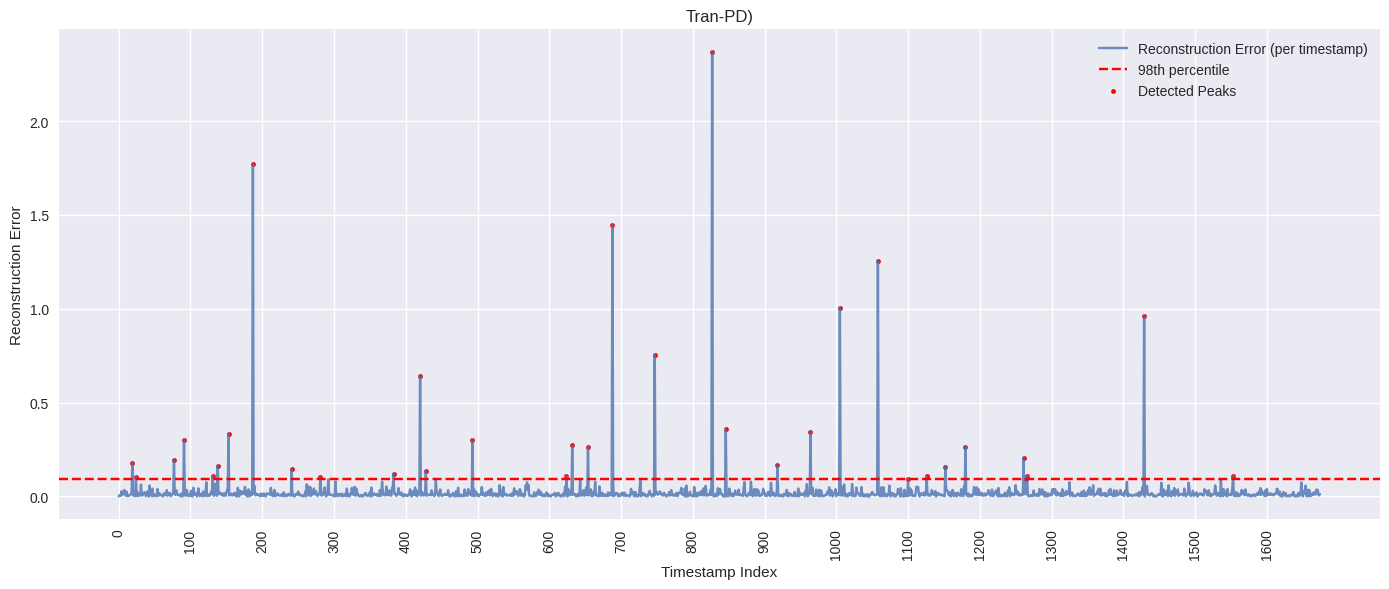


 DONE - 34 Peaks Detected


In [20]:
errors, peaks, true_orig, recon_orig, threshold = plot_reconstruction_errors_per_timestep(model, scaler_y, X_test_tensor)

print(f"\n DONE - {len(peaks)} Peaks Detected")

### Save Errors and Peaks

In [21]:
X_test['True_Value'] = true_orig
X_test['Reconstructed_Value'] = recon_orig
X_test['Reconstruction_Error'] = errors
X_test['Peak'] = (errors > threshold).astype(int)

# Save
output_path = "/content/X_test_with_peaks.csv"
X_test.to_csv(output_path, index=False)
print(f" Saved test set with peaks to: {output_path}")

 Saved test set with peaks to: /content/X_test_with_peaks.csv


### Save Peaks Details into Dataset

In [22]:
start_index = window_size
timestamp_indices = np.arange(start_index, start_index + len(true_orig))

# Create the Peaks dataset
Peaks = pd.DataFrame({
    'Timestamp': timestamp_indices,
    'True_Value': true_orig,
    'Reconstructed_Value': recon_orig,
    'Reconstruction_Error': errors,
    'Peak': (errors > threshold).astype(int)
})

Peaks.to_csv("/content/Peaks.csv", index=False)
print("Saved Peaks dataset to: /content/Peaks.csv")

Saved Peaks dataset to: /content/Peaks.csv


### Interactive Plot

In [23]:
import plotly.graph_objects as go
import pandas as pd

# Load  dataset
peaks_df = pd.read_csv("/content/Peaks.csv")  # Adjust path if needed

# Create interactive line plot
fig = go.Figure()

# Line: Reconstruction Error
fig.add_trace(go.Scatter(
    x=peaks_df["Timestamp"],
    y=peaks_df["Reconstruction_Error"],
    mode='lines',
    name='Reconstruction Error',
    line=dict(color='blue')
))

# Points: Detected Peaks
fig.add_trace(go.Scatter(
    x=peaks_df.loc[peaks_df["Peak"] == 1, "Timestamp"],
    y=peaks_df.loc[peaks_df["Peak"] == 1, "Reconstruction_Error"],
    mode='markers',
    name='Detected Peaks',
    marker=dict(color='red', size=8, symbol='circle'),
    hovertemplate='Timestamp: %{x}<br>Error: %{y:.4f}'
))

# Layout adjustments
fig.update_layout(
    title="Interactive Reconstruction Error",
    xaxis_title="Timestamp",
    yaxis_title="Reconstruction Error",
    legend=dict(x=0.01, y=0.99),
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

## To shorten Dataset Length

In [3]:

df = pd.read_csv("/content/DMC2_S_CP2_52.csv")

# Take 20% of the data
df_20 = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

# Save to new file
df_20.to_csv("/content/dataset_20.csv", index=False)

print("✅ New file 'dataset_20.csv' created with 20% of the data.")

✅ New file 'dataset_20.csv' created with 20% of the data.


### Datasset Info

In [ ]:
df_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8403 entries, 0 to 8402
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LOAD|1        8403 non-null   float64
 1   LOAD|2        8403 non-null   float64
 2   LOAD|3        8403 non-null   float64
 3   LOAD|6        8403 non-null   float64
 4   ENC_POS|1     8403 non-null   float64
 5   ENC_POS|2     8403 non-null   float64
 6   ENC_POS|3     8403 non-null   float64
 7   ENC_POS|6     8403 non-null   float64
 8   CTRL_DIFF2|1  8403 non-null   float64
 9   CTRL_DIFF2|2  8403 non-null   float64
 10  CTRL_DIFF2|3  8403 non-null   float64
 11  CTRL_DIFF2|6  8403 non-null   float64
 12  TORQUE|1      8403 non-null   float64
 13  TORQUE|2      8403 non-null   float64
 14  TORQUE|3      8403 non-null   float64
 15  TORQUE|6      8403 non-null   float64
 16  DES_POS|1     8403 non-null   float64
 17  DES_POS|2     8403 non-null   float64
 18  DES_POS|3     8403 non-null 

In [ ]:
df.shape

(42016, 56)

## IMP Code snippets

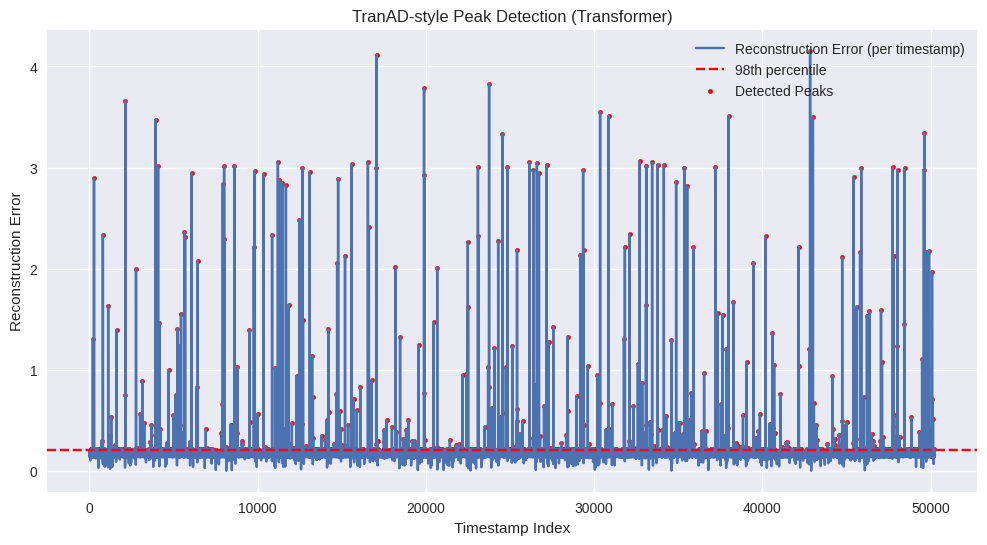


✅ DONE - 1003 Peaks Detected


In [ ]:

def plot_reconstruction_errors_per_timestep(model, scaler_y, X_input, threshold_percentile=98):
    model.eval()
    with torch.no_grad():
        x2 = model(X_input, X_input)
        recon = x2.cpu().numpy().reshape(-1, 1)
        true = X_input.cpu().numpy().reshape(-1, 1)
        recon_orig = scaler_y.inverse_transform(recon).flatten()
        true_orig = scaler_y.inverse_transform(true).flatten()
        errors = np.abs(true_orig - recon_orig)

        threshold = np.percentile(errors, threshold_percentile)
        peaks = [i for i, e in enumerate(errors) if e > threshold]

        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(errors, label="Reconstruction Error (per timestamp)")
        plt.axhline(threshold, color="red", linestyle="--", label=f"{threshold_percentile}th percentile")
        plt.scatter(peaks, [errors[i] for i in peaks], color='red', s=10, label="Detected Peaks")
        plt.title("TranAD-style Peak Detection (Transformer)")
        plt.xlabel("Timestamp Index")
        plt.ylabel("Reconstruction Error")
        plt.legend()
        plt.grid(True)
        plt.show()

        return errors, peaks

# 9. Run and Plot
errors, peaks = plot_reconstruction_errors_per_timestep(model, scaler_y, X_test_tensor)
print(f"\n✅ DONE - {len(peaks)} Peaks Detected")




## Dataset
not_non_features = [
       'LOAD|1', 'LOAD|2', 'LOAD|3', 'LOAD|6',
       'ENC_POS|1', 'ENC_POS|2', 'ENC_POS|3','ENC_POS|6',
       'CTRL_DIFF2|1', 'CTRL_DIFF2|2', 'CTRL_DIFF2|3', 'CTRL_DIFF2|6',
       'TORQUE|1', 'TORQUE|2', 'TORQUE|3', 'TORQUE|6',
       'DES_POS|1', 'DES_POS|2', 'DES_POS|3', 'DES_POS|6',

       #'CURRENT|1', 'CURRENT|2', 'CURRENT|3',


       'CTRL_DIFF|1', 'CTRL_DIFF|2', 'CTRL_DIFF|3' ,'CTRL_DIFF|6',
       'CTRL_POS|1', 'CTRL_POS|2', 'CTRL_POS|3', 'CTRL_POS|6',
       'VEL_FFW|1', 'VEL_FFW|2','VEL_FFW|3', 'VEL_FFW|6',
       #'POWER|1','POWER|2', 'POWER|3', 'POWER|6',
       'CONT_DEV|1','CONT_DEV|2', 'CONT_DEV|3', 'CONT_DEV|6',
       #'A_DBD|0',
       'CMD_SPEED|1', 'CMD_SPEED|2', 'CMD_SPEED|3', 'CMD_SPEED|6',
       'TORQUE_FFW|1', 'TORQUE_FFW|2', 'TORQUE_FFW|3', 'TORQUE_FFW|6',
       'ENC1_POS|1', 'ENC1_POS|2', 'ENC1_POS|3','ENC1_POS|6',
       'ENC2_POS|1', 'ENC2_POS|2', 'ENC2_POS|3', 'ENC2_POS|6']
target = 'CURRENT|6'